# ***Libraries***

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import json
import random 
import pandas as pd 
import numpy as np
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix
from tabulate import tabulate
import ast

import openai
from openai import OpenAI

# model_name = 'gpt-4o-2024-11-20'
api_key = 'Your OpenAI Token' #rs_user_description

client = OpenAI(
    # This is the default and can be omitted
    api_key=api_key,
)

label_map = {0:'Healthy', 1:'AD'}

# ***Data Construction***

## ***Constant Variables***

In [ ]:
# System instruction for chat template
classification_system_prompt = """You are an expert cognitive impairment analyst.
Your role is to evaluate spoken language transcripts and classify them based on linguistic patterns.
"""

# Task prompt to finetune and inference
classification_task_prompts =(
    "You are an expert in cognitive health and language analysis. You will analyze a spoken language transcript from a person describing the 'cookie theft' picture. This is not written text but a transcription of spontaneous speech."
    "\nAnalyze the provided transcript and classify it into one of two categories: 'Healthy' for a healthy cognitive state or 'AD' for Alzheimer's disease."
    "\nProvide only the label ('Healthy' or 'AD') as the output. Do not include explanations or additional text."
    "\nText: {text}"
    "\nLabel:"
)

train_data_path = 'D:/speechADRD/dataSynthesis/data/train.csv'
valid_data_path = 'D:/speechADRD/dataSynthesis/data/validation.csv'
test_data_path = 'D:/speechADRD/dataSynthesis/data/Test_DePiC.xlsx'

train_out_file = 'D:/speechADRD/dataSynthesis/classification/gpt/input_data/train.jsonl'
valid_out_file = 'D:/speechADRD/dataSynthesis/classification/gpt/input_data/valid.jsonl'

## ***Build Dataset***

In [ ]:
def save_to_jsonl(data, output_file_path):
    """
    Converts a dataset into JSONL format for GPT fine-tuning.
    Each row is transformed into a structured conversation.
    """
    jsonl_data = []
    for index, row in data.iterrows():
        # Format the user prompt with text from the dataset
        prompt = classification_task_prompts.format(text=row['text'])

        # Construct a chat-style message structure
        jsonl_data.append({
            "messages": [
                {"role": "system", "content": classification_system_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": label_map[row['label']]}
            ]
        })

    # Write data to JSONL file (one JSON object per line)
    with open(output_file_path, 'w') as f:
        for item in jsonl_data:
            f.write(json.dumps(item) + '\n')

    return jsonl_data


In [12]:
train_df = pd.read_csv(train_data_path)
valid_df = pd.read_csv(valid_data_path)

train_data = save_to_jsonl(train_df, train_out_file)
valid_data = save_to_jsonl(valid_df, valid_out_file)

## ***Chack Data***

In [ ]:
def check_data(dataset):
    """
    Validate dataset format for GPT fine-tuning.
    Checks for structural issues in message dictionaries.
    """
    # Track error types and their counts
    format_errors = defaultdict(int)

    for ex in dataset:
        # Each example must be a dict
        if not isinstance(ex, dict):
            format_errors["data_type"] += 1
            continue
            
        messages = ex.get("messages", None)
        if not messages:
            format_errors["missing_messages_list"] += 1
            continue
            
        for message in messages:
            # Ensure required keys exist
            if "role" not in message or "content" not in message:
                format_errors["message_missing_key"] += 1
            
            # Detect unexpected keys
            if any(k not in ("role", "content", "name", "function_call", "weight") for k in message):
                format_errors["message_unrecognized_key"] += 1
            
            # Validate role values
            if message.get("role", None) not in ("system", "user", "assistant", "function"):
                format_errors["unrecognized_role"] += 1
                
            content = message.get("content", None)
            function_call = message.get("function_call", None)
            
            # Ensure content exists (unless function_call is used) and is a string
            if (not content and not function_call) or not isinstance(content, str):
                format_errors["missing_content"] += 1
        
        # At least one assistant response must be present per example
        if not any(message.get("role", None) == "assistant" for message in messages):
            format_errors["example_missing_assistant_message"] += 1

    # Report summary of issues found
    if format_errors:
        print("Found errors:")
        for k, v in format_errors.items():
            print(f"{k}: {v}")
    else:
        print("No errors found")
        
        
# Run validation on training and validation splits
check_data(train_data)
check_data(valid_data)


No errors found
No errors found


## ***Upload Datasets***

In [ ]:
train_file = client.files.create(
  file=open(train_out_file, "rb"),
  purpose="fine-tune"
)

valid_file = client.files.create(
  file=open(valid_out_file, "rb"),
  purpose="fine-tune"
)

print(f"Training file Info: {train_file}")
print(f"Validation file Info: {valid_file}")

In [10]:
train_file = client.files.retrieve('file-G5UEcc5jBrDLMFgReTggDd')
valid_file = client.files.retrieve('file-P5fjycD2JDjjNWtJCrJdfk')

# ***Tune Model***

## ***Creat a Job***

You may change the hyperparameters.

In [ ]:
# Start a fine-tuning job using specified training/validation files and hyperparameters
model = client.fine_tuning.jobs.create(
    training_file=train_file.id, 
    validation_file=valid_file.id,
    model="gpt-4o-2024-08-06",  # base model to fine-tune
    hyperparameters={
        "n_epochs": 3,
        "batch_size": 16,
        "learning_rate_multiplier": 1.8
    }
)

# Extract job metadata for tracking
job_id = model.id
status = model.status

# Log job details
print(f'Fine-tuning model with jobID: {job_id}.')
print(f"Training Response: {model}")
print(f"Training Status: {status}")

## ***Check Status***

In [14]:
# Retrieve the state of a fine-tune
client.fine_tuning.jobs.retrieve(job_id).status

'succeeded'

## ***Train and Validation Metrics***

In [ ]:
# Retrieve result file IDs for the fine-tuning job
fine_tune_results = client.fine_tuning.jobs.retrieve(job_id).result_files

# Get metadata for the first result file
result_file = client.files.retrieve(fine_tune_results[0])

# Download result file content (base64 encoded)
content = client.files.content(result_file.id)

# Decode and save results locally as CSV
import base64
with open('D:/speechADRD/dataSynthesis/classification/gpt/gptFinetuning_results4.csv', 'wb') as f:
    f.write(base64.b64decode(content.text.encode('utf-8')))


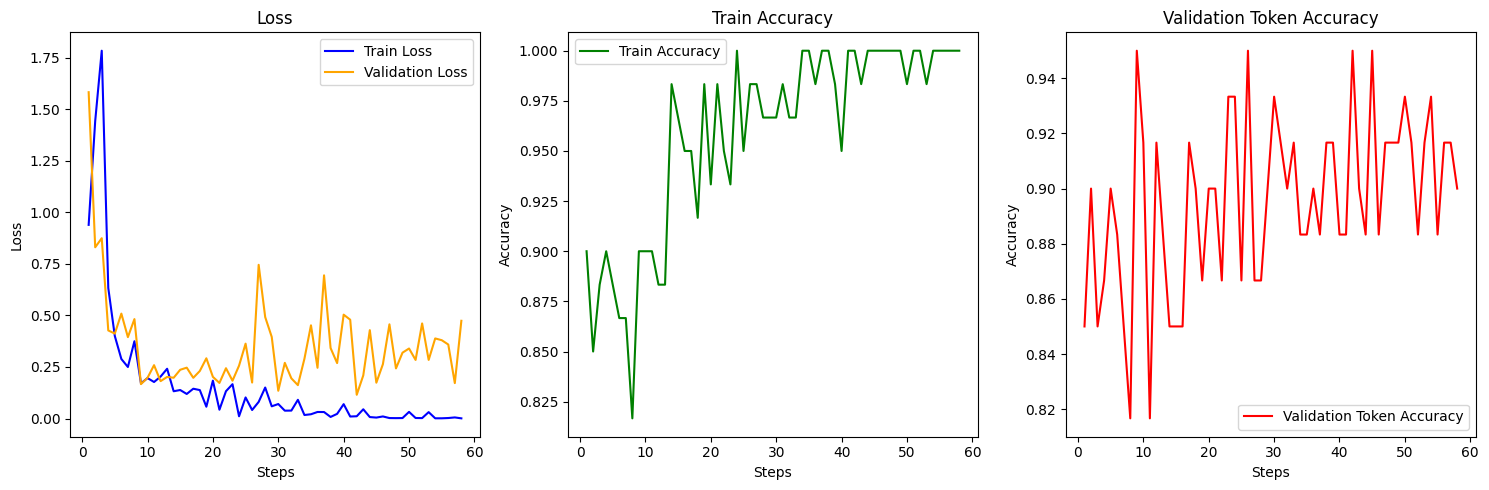

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame (update 'file_path' to your actual file path)
file_path = 'D:/speechADRD/dataSynthesis/classification/gpt/gptFinetuning_results3.csv'
df = pd.read_csv(file_path)

# Handle missing values for validation metrics by forward-filling
# (Assuming validation values are NaN for steps where they're not available)
df['valid_loss'] = df['valid_loss'].fillna(method='ffill')
df['valid_mean_token_accuracy'] = df['valid_mean_token_accuracy'].fillna(method='ffill')

# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot train_loss and valid_loss on the first subplot
axes[0].plot(df['step'], df['train_loss'], label='Train Loss', color='blue')
axes[0].plot(df['step'], df['valid_loss'], label='Validation Loss', color='orange')
axes[0].set_title('Loss')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot train_accuracy on the second subplot
axes[1].plot(df['step'], df['train_accuracy'], label='Train Accuracy', color='green')
axes[1].set_title('Train Accuracy')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Plot valid_mean_token_accuracy on the third subplot
axes[2].plot(df['step'], df['valid_mean_token_accuracy'], label='Validation Token Accuracy', color='red')
axes[2].set_title('Validation Token Accuracy')
axes[2].set_xlabel('Steps')
axes[2].set_ylabel('Accuracy')
axes[2].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## ***Checkpoints***

In [ ]:
model_checkpoin_list = client.fine_tuning.jobs.checkpoints.list('ftjob-8KNImL5nzXDsaGYwj2hfaeEV')
# print(model_checkpoin_list)
checkpoint_names = []
for chckpnt in model_checkpoin_list:
    print(f'model id: {chckpnt.id}')
    print(f'model name: {chckpnt.fine_tuned_model_checkpoint}')
    checkpoint_names.append(chckpnt.fine_tuned_model_checkpoint)
    print(f'step number: {chckpnt.step_number}')
    print(f'valid loss: {chckpnt.metrics.full_valid_loss}')
    print(f'valid accuracy: {chckpnt.metrics.full_valid_mean_token_accuracy}')
    print('\n\n')

# ***Use Trained Model***

## ***Utils***

In [35]:
def map_label(pred_text):
    if pred_text:
        if "health" in pred_text.lower() or "he" in pred_text.lower():
            return 0
        elif "ad" in pred_text.lower():
            return 1
    return None


def chat_with_llm(model_id, system_message, user_instruction):
    chat_response = client.chat.completions.create(
    model=model_id, 
    messages=[
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_instruction},
    ],
    temperature=1e-15,
    logprobs=True,
    top_logprobs=5,
    )
    return chat_response.choices[0].message.content, chat_response.choices[0].logprobs.content[0].top_logprobs

def extract_token_probs(top_3_log_probs):
    """Extract log probabilities for 'Healthy' and 'AD' tokens and apply softmax if both exist."""
    token_probs = {entry.token: entry.logprob for entry in top_3_log_probs}

    healthy_logprob = token_probs.get("Healthy", None)
    ad_logprob = token_probs.get("AD", None)

    if healthy_logprob is not None and ad_logprob is not None:
        # Convert log probs to probabilities using softmax
        probs = np.exp([healthy_logprob, ad_logprob])
        probs /= np.sum(probs)
        return probs[0], probs[1]
    
    elif healthy_logprob is not None:
        return np.exp(healthy_logprob), None

    elif ad_logprob is not None:
        return None, np.exp(ad_logprob)

    return None, None


def load_existing_results(save_path):
    """Load already inferred results from JSON file if it exists."""
    if os.path.exists(save_path):
        with open(save_path, "r") as f:
            return {entry["text"]: entry for entry in json.load(f)}
    return {}


def save_results_incrementally(save_path, result):
    """Save each inference result incrementally in JSON format."""
    existing_data = load_existing_results(save_path)
    existing_data[result["text"]] = result  # Ensure unique entries
    with open(save_path, "w") as f:
        json.dump(list(existing_data.values()), f, indent=4)


def inference_tuned_model(model_id, data, save_path):
    """Perform inference while skipping already processed rows and saving incrementally."""
    
    # Load already inferred results
    existing_results = load_existing_results(save_path)
    
    results = []
    top_3_log_probs_list = []
    
    for i, row in tqdm(data.iterrows(), total=len(data)):
        text = row['text']

        # Skip if already processed
        if text in existing_results:
            continue

        # Prepare prompt
        prompt = classification_task_prompts.format(text=text)
        pred_text, top_3_log_probs = chat_with_llm(model_id, classification_system_prompt, prompt)
        pred_label = map_label(pred_text)

        # Extract token probabilities
        healthy_prob, ad_prob = extract_token_probs(top_3_log_probs)

        # Create result entry
        result = {
            "text": text,
            "input": prompt,
            "label": row['label'],
            "pred_text": pred_text,
            "pred_label": pred_label,
            "healthy_token_prob": healthy_prob,
            "ad_token_prob": ad_prob
        }

        # Save incrementally
        save_results_incrementally(save_path, result)
        results.append(result)
        top_3_log_probs_list.append(top_3_log_probs)

    return results, top_3_log_probs_list



def compute_classification_metrics(df, label_col='label', pred_col='pred_label'):
    """
    Computes precision, recall, F1-score, and confusion matrix values (TP, TN, FP, FN).
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the true labels and predicted labels.
    label_col (str): Column name for true labels.
    pred_col (str): Column name for predicted labels.

    Returns:
    dict: A dictionary containing precision, recall, F1-score, TP, TN, FP, and FN.
    """
    y_true = df[label_col]
    y_pred = df[pred_col]

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    }

def display_metrics(val_df, test_df):#train_df, 
    """
    Computes and displays precision, recall, F1-score, and confusion matrix values for train, validation, and test sets.
    
    Parameters:
    train_df, val_df, test_df (pd.DataFrame): DataFrames containing labels and predictions.
    """
    results = {
        # "Train": compute_classification_metrics(train_df),
        "Validation": compute_classification_metrics(val_df),
        "Test": compute_classification_metrics(test_df)
    }

    # Convert results to tabular format
    table_data = []
    for dataset, metrics in results.items():
        table_data.append([
            dataset, metrics['Precision'], metrics['Recall'], metrics['F1-score'],
            metrics['TP'], metrics['TN'], metrics['FP'], metrics['FN']
        ])

    # Print table
    print(tabulate(table_data, headers=["Dataset", "Precision", "Recall", "F1-score", "TP", "TN", "FP", "FN"], tablefmt="grid"))


def merge_with_original_data(original_df, inference_json_path):
    """Merge the original dataset with inference results based on the text column."""
    
    # Load the original dataset
    # original_df = pd.read_csv(original_data_path)  # Ensure this CSV contains labels
    
    # Load inference results
    inferred_df = pd.read_json(inference_json_path)

    # Merge both on 'text' column to retain labels
    merged_df = original_df.merge(inferred_df, on="text", how="left")

    return merged_df

## ***Evaluation*** -  Train3 - Epochs=10, LRM=2.5, BS=20

In [ ]:
for i, chkpnt in enumerate(checkpoint_names):
    print(chkpnt)

    # Load validation and test sets
    valid_data = pd.read_csv(valid_data_path)
    test_data = pd.read_excel(test_data_path)

    # Run inference on validation set with current checkpoint
    modif_valid_data = pd.DataFrame(
        inference_tuned_model(
            chkpnt,
            valid_data,
            f"D:/speechADRD/dataSynthesis/classification/gpt/predictions/bs20_ep10_lrM2.5_withProb_valid_predictions_chkpnt{i}.json"
        )
    )

    # Run inference on test set with current checkpoint
    modif_test_data = pd.DataFrame(
        inference_tuned_model(
            chkpnt,
            test_data,
            f"D:/speechADRD/dataSynthesis/classification/gpt/predictions/bs20_ep10_lrM2.5_withProb_test_predictions_chkpnt{i}.json"
        )
    )

    # Ensure prediction labels are integer type
    modif_valid_data['pred_label'] = modif_valid_data[['pred_label']].astype(int)
    modif_test_data['pred_label'] = modif_test_data[['pred_label']].astype(int)

    # Evaluate model performance on validation and test sets
    display_metrics(modif_valid_data, modif_test_data)


ft:gpt-4o-2024-08-06:personal::BBLCBiea


100%|██████████| 71/71 [01:14<00:00,  1.04s/it]


+------------+-------------+----------+------------+------+------+------+------+
| Dataset    |   Precision |   Recall |   F1-score |   TP |   TN |   FP |   FN |
+============+=============+==========+============+======+======+======+======+
| Validation |    0.730769 | 0.703704 |   0.716981 |   19 |   16 |    7 |    8 |
+------------+-------------+----------+------------+------+------+------+------+
| Test       |    0.742857 | 0.742857 |   0.742857 |   26 |   27 |    9 |    9 |
+------------+-------------+----------+------------+------+------+------+------+
ft:gpt-4o-2024-08-06:personal::BBLCB7KU:ckpt-step-54


100%|██████████| 71/71 [01:57<00:00,  1.66s/it]


+------------+-------------+----------+------------+------+------+------+------+
| Dataset    |   Precision |   Recall |   F1-score |   TP |   TN |   FP |   FN |
+============+=============+==========+============+======+======+======+======+
| Validation |    0.7      | 0.777778 |   0.736842 |   21 |   14 |    9 |    6 |
+------------+-------------+----------+------------+------+------+------+------+
| Test       |    0.764706 | 0.742857 |   0.753623 |   26 |   28 |    8 |    9 |
+------------+-------------+----------+------------+------+------+------+------+
ft:gpt-4o-2024-08-06:personal::BBLCA0Ju:ckpt-step-48


100%|██████████| 71/71 [01:28<00:00,  1.25s/it]

+------------+-------------+----------+------------+------+------+------+------+
| Dataset    |   Precision |   Recall |   F1-score |   TP |   TN |   FP |   FN |
+============+=============+==========+============+======+======+======+======+
| Validation |    0.6875   | 0.814815 |   0.745763 |   22 |   13 |   10 |    5 |
+------------+-------------+----------+------------+------+------+------+------+
| Test       |    0.777778 | 0.8      |   0.788732 |   28 |   28 |    8 |    7 |
+------------+-------------+----------+------------+------+------+------+------+
